This notebook reads in the unfiltered, unwrapped igrams and does some histogram stuff with them.

1. reads in unfilt unwrapped igrams 
2. produces histograms of phase in two regions (used this figure in AGU poster before unfilt unwrapped igrams were corrected)
3. calculates skewness over time (sequential igrams). <br><br>


This notebook was written on 1-30-23. Edited 1-31-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
%matplotlib  widget

Read in unfiltered, unwrapped igrams. Can take a few minutes.

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
# loop through the dates 
for i in range(numIgrams): # numIgrams if doing all of them at once
    date1=dates[i]
    date2=dates[i+1]
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('unfiltered unwrapped igrams loaded.')

unfiltered unwrapped igrams loaded.


Now plot a sample interferogram with boxes outlines of a group of pixels in LS and in open desert. A histogram of these pixels (phase change at each) is produced in the next cell, to show that they are behaving differently overall. 

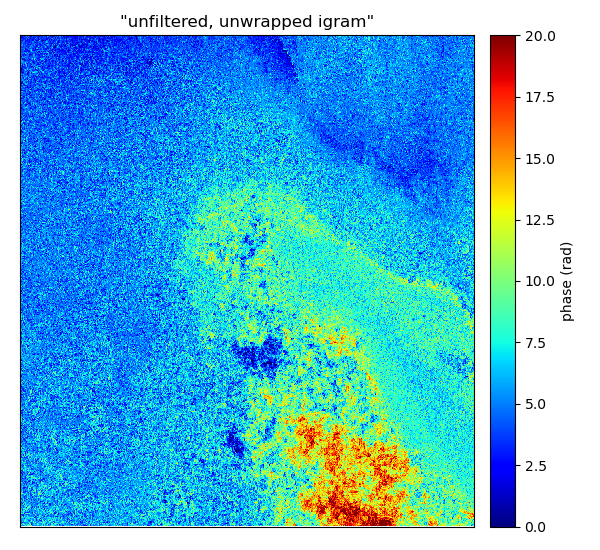

In [3]:
# sample igrams for Geol.Sci.Seminar 3-17-23
k = 10
k = 73

date1 = dates[k]; date2 = dates[k+1]
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=0,vmax=20)
#plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-3,vmax=4)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
#plt.xlabel('range'); plt.ylabel('azimuth')
#plt.title(str(date1)+'-'+str(date2)+' igram',fontsize=15) 
plt.title('\"unfiltered, unwrapped igram\"')
plt.show()
#plt.savefig("sample_igram_1_AGU.png", transparent=True)

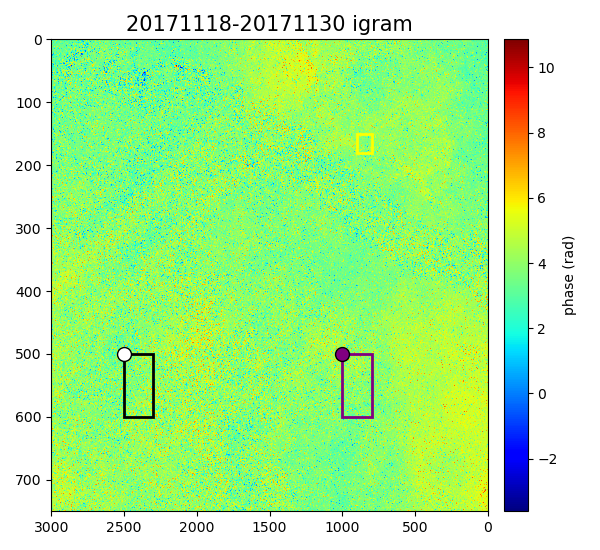

In [4]:
# sample igrams for AGU poster 12-7-22
#k = 15 # which igram to plot? 
k = 59 # wet1
k = 15 # dry1

#k = 10

date1 = dates[k]; date2 = dates[k+1]
plt.figure(figsize=(6,5.5),tight_layout=True) 
plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0]) #vmin=0,vmax=8
#plt.imshow(unwr_full_res[k],aspect='auto',interpolation='nearest',extent=[0,dx,dy,0],vmin=-3,vmax=4)
plt.colorbar(orientation='vertical',pad=0.03,label='phase (rad)'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.title(str(date1)+'-'+str(date2)+' igram',fontsize=15)
plt.gca().add_patch(Rectangle((2300,500),200,100,edgecolor='k',facecolor='none',linewidth=2))
plt.gca().add_patch(Rectangle((800,500),200,100,edgecolor='purple',facecolor='none',linewidth=2))
plt.plot(2500,500,'o',color='white',markersize=10,mec='k') # a
plt.plot(1000,500,'o',color='purple',markersize=10,mec='k') # b
# add another box for the area I'll use as the reference region later. 
# This is to try to correct for VERY high rates of disp on my maps of disp over 5 different time intervals. 
plt.gca().add_patch(Rectangle((800,150),100,30,edgecolor='yellow',facecolor='none',linewidth=2))
# 800:900,150:180
# 500:600,2300:2500
# 500:600,1300:1500
plt.show()
#plt.savefig("sample_igram_1_AGU.png", transparent=True)

Make a histogram of the phase change in the pixels boxed in above. This shows that, despite the difference in graininess which may mislead the eye, the two surface types are behaving differently and LS does actually have a different displacement rate than the surrounding open desert. 

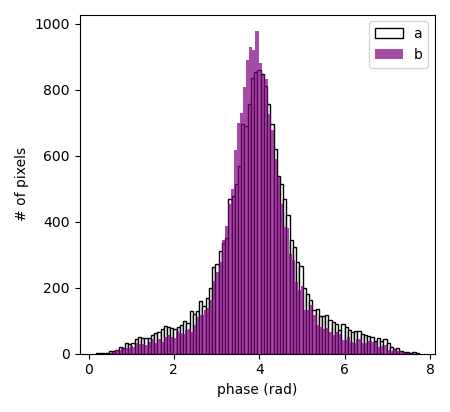

desert: [3.9553123]
LS: [3.90979744]


In [5]:
# make histogram of pixels in LS and pixels outside of LS
hist_desert = (unwr_full_res[k,500:600,2300:2500]).flatten()
hist_LS = (unwr_full_res[k,500:600,800:1000]).flatten()

plt.figure(figsize=(4.5,4.125),tight_layout=True) 
ytemp,xtemp,_ = plt.hist(hist_desert,bins=100,color='white',label='a',edgecolor='k')
ytemp1,xtemp1,_ = plt.hist(hist_LS,bins=100,color='purple',alpha=0.7,label='b')
plt.xlabel('phase (rad)'); plt.ylabel('# of pixels')
plt.legend()
plt.show()

print('desert: '+str(xtemp[np.where(ytemp == ytemp.max())]))
print('LS: '+str(xtemp1[np.where(ytemp1 == ytemp1.max())]))

#plt.savefig("sample_igram_1_hist_AGU.png", transparent=True)

Read in precip data to plot as vertical lines on skewness over time plots.

In [6]:
# Read in 2day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip_2days.txt', dtype='float')
#precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_cumulative.txt', dtype='float')

# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[1::]


# BIGGER STORMS
# days with precip > 0.3cm 
#print('i \tdate \t\t       precip > 0.3cm')
print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.0:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

i 	date 		       precip > 0.0cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
55	2019-03-13 00:00:00    0.0762 cm
59	2019-05-12 00:00:00    0.10160000000000001 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
86	2019-12-08 00:00:00    0.254 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
103	2020-03-19 00:00:00    0.254 cm
107	2020-04-12 00:00:00    0.9906 cm
154	2021-01-25 00:00:00    0.0762 cm
186	2021-08-11 00:00:00    0.381 cm


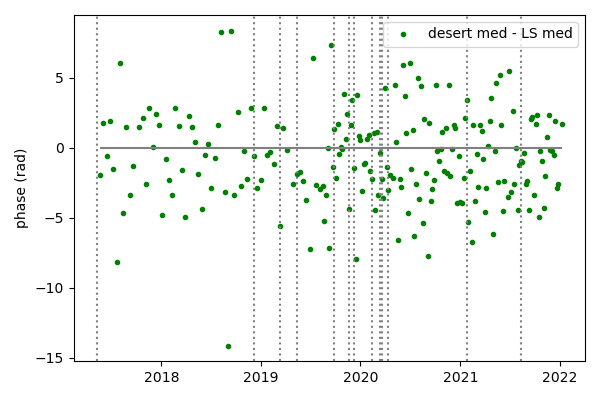

In [7]:
med_diffs = np.zeros((numIgrams,))
mean_diffs = np.zeros((numIgrams,))
stds_LS = np.zeros((numIgrams,))
stds_desert = np.zeros((numIgrams,))

for i in range(numIgrams):
    med_diffs[i] = np.median((unwr_full_res[i,500:600,2300:2500]).flatten())-np.median((unwr_full_res[k,500:600,800:1000]).flatten())
    mean_diffs[i] = np.mean((unwr_full_res[i,500:600,2300:2500]).flatten())-np.mean((unwr_full_res[k,500:600,800:1000]).flatten())
    stds_LS[i] = np.std((unwr_full_res[i,500:600,800:1000]).flatten())
    stds_desert[i] = np.std((unwr_full_res[i,500:600,2300:2500]).flatten())

plt.figure(figsize=(6,4),tight_layout=True) 
plt.plot(igram_dates,med_diffs,'g.',label='desert med - LS med')
#plt.plot(igram_dates,mean_diffs,'b.',label='desert mean - LS mean')
#plt.plot(igram_dates,stds_LS,'.',color='purple',label='std. LS (b)')
#plt.plot(igram_dates,stds_desert,'.k',label='std. desert (a)')
plt.hlines(0,igram_dates[0],igram_dates[-1],'gray')
plt.ylabel('phase (rad)')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.legend()
plt.show()

Calculate skewness in these boxes, over time.

In [8]:
# initialize arrays to hold skewness values 
skew_vals_desert = np.ones(numIgrams)
skew_vals_LS = np.ones(numIgrams)
# loop through igrams 
for k in range(numIgrams):
    # pull out pixels from the two boxes for this igram 
    hist_desert = (unwr_full_res[k,500:600,2300:2500]).flatten()
    hist_LS = (unwr_full_res[k,500:600,800:1000]).flatten()
    skew_vals_desert[k] = skew(hist_desert)
    skew_vals_LS[k] = skew(hist_LS)
# print('LS: '+str(skew_LS))
# print('desert: '+str(skew_desert))

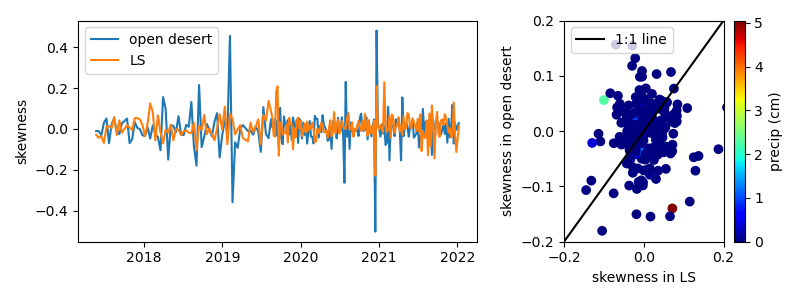

R-val: 0.2339890623045678


In [9]:
plt.subplots(1,2,figsize=(8,3),tight_layout='TRUE',gridspec_kw={'width_ratios': [2,1]})
plt.subplot(1,2,1)
plt.plot(igram_dates,skew_vals_desert,label='open desert')
plt.plot(igram_dates,skew_vals_LS,label='LS')
plt.legend(); plt.ylabel('skewness')
plt.subplot(1,2,2)
plt.scatter(skew_vals_LS,skew_vals_desert,c=precip[0:-1])
plt.ylabel('skewness in open desert'); plt.xlabel('skewness in LS')
ymin,ymax = plt.ylim()
plt.plot([ymin,ymax],[ymin,ymax],'k-',label='1:1 line')
plt.colorbar(label='precip (cm)'); plt.legend()
plt.xlim([-0.2,0.2]); plt.ylim([-0.2,0.2])
plt.show()

r_val = np.corrcoef(skew_vals_LS,skew_vals_desert)
print('R-val: '+str(r_val[0,1]))

Calculate skewness values for every pixel (except edge pixels) over a moving 4x20 window. 
<br> This takes a few (>10) minutes.

In [10]:
alooks = 8      # y-direction, start with 4
rlooks = 40     # x-direction, start with 20
# choose an interferogram to calculate skewness on
k=30
skew_vals = np.zeros((dy,dx))
std_devs = np.zeros((dy,dx))
for y in range(dy):       # dy for all pixels 
    for x in range(dx):   # dx for all pixels 
        if y-alooks/2 < 0 or y+alooks/2 >= dy or x-rlooks/2 < 0 or x+rlooks/2 >= dx:
            skew_vals[y,x] = float('nan')
            std_devs[y,x] = float('nan')
            #print('('+str(y)+','+str(x)+') nan')
        else: 
            #skew_vals[y,x] = skew(unwr_full_res[k,y-int(alooks/2):y+int(alooks/2),x-int(rlooks/2):x+int(rlooks/2)])
            skew_vals[y,x] = skew((unwr_full_res[k,y-int(alooks/2):y+int(alooks/2),x-int(rlooks/2):x+int(rlooks/2)]).flatten())
            std_devs[y,x] = np.std((unwr_full_res[k,y-int(alooks/2):y+int(alooks/2),x-int(rlooks/2):x+int(rlooks/2)]).flatten())
            #print('('+str(y)+','+str(x)+') skew')
print('skew + std. dev. values calculated for all pixels of this igram.')

skew + std. dev. values calculated for all pixels of this igram.


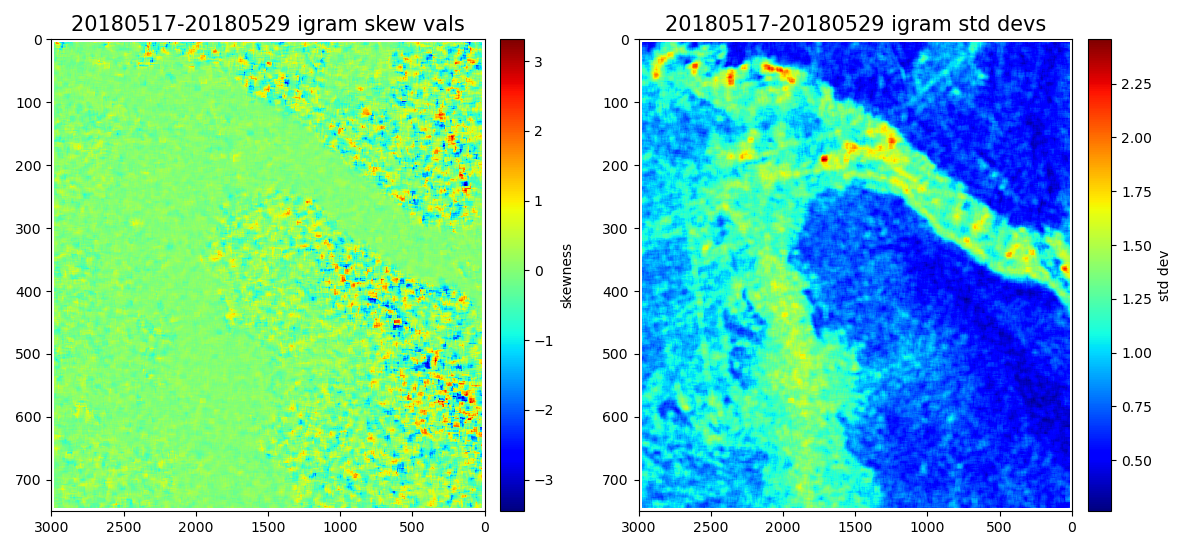

In [11]:
date1 = dates[k]; date2 = dates[k+1]
plt.figure(figsize=(12,5.5),tight_layout=True) 
plt.subplot(1,2,1)
plt.imshow(skew_vals,aspect='auto',interpolation='nearest',extent=[0,dx,dy,0]) #,vmin=-0.5,vmax=0.5
plt.colorbar(orientation='vertical',pad=0.03,label='skewness'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.title(str(date1)+'-'+str(date2)+' igram skew vals',fontsize=15)
plt.subplot(1,2,2)
plt.imshow(std_devs,aspect='auto',interpolation='nearest',extent=[0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.03,label='std dev'); plt.set_cmap('jet')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title(str(date1)+'-'+str(date2)+' igram std devs',fontsize=15)
plt.show()
#plt.savefig("sample_igram_1_AGU.png", transparent=True)

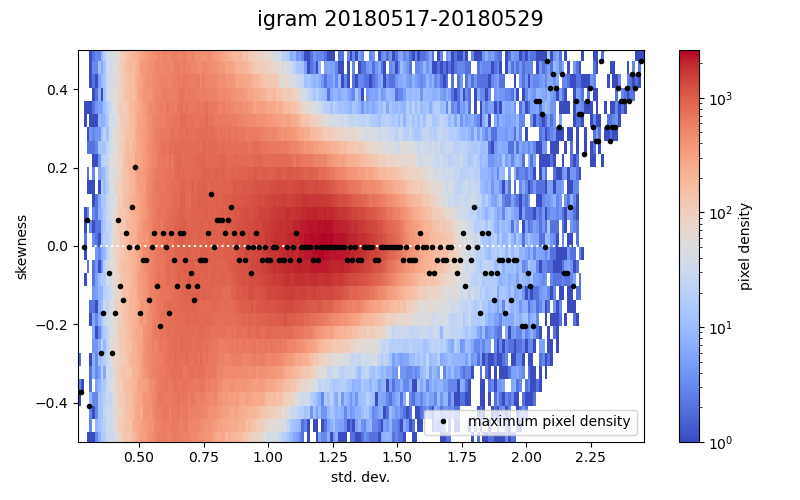

In [12]:
std_devs_middle = std_devs[int(alooks/2):dy-int(alooks/2),int(rlooks/2):dx-int(rlooks/2)].flatten()
skew_vals_middle = skew_vals[int(alooks/2):dy-int(alooks/2),int(rlooks/2):dx-int(rlooks/2)].flatten()
# heatmap, xedges, yedges = np.histogram2d(std_devs_middle,skew_vals_middle, bins=100)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(8,5),tight_layout='TRUE')
# plt.imshow(heatmap.T, extent=extent, origin='lower')
numBins = 200
h = plt.hist2d(std_devs_middle,skew_vals_middle,bins=numBins,norm=mcolors.LogNorm()) #,cmin=1,cmax=1000
vals = h[0]; x = h[1]; y = h[2]
plt.colorbar(label='pixel density'); plt.set_cmap('coolwarm') # plasma is original 
plt.hlines(0,x[0],x[-1],colors='white',linestyles=':')
max_skew_indices = np.argmax(vals,axis=1)
max_skew_vals = np.take(y,max_skew_indices)
plt.plot(x[0:-1],max_skew_vals,'k.',label='maximum pixel density')
plt.xlabel('std. dev.'); plt.ylabel('skewness'); plt.legend()
plt.ylim([-0.5,0.5])
plt.suptitle('igram '+str(date1)+'-'+str(date2),fontsize=15)
plt.show() 

In [13]:
print(dates[46],dates[47])

20181125 20181207
